## ¿Cómo trabajar con los resultados de segmentación?

In [1]:
# Cargar las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt

from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import (active_contour, felzenszwalb, quickshift, 
                                 mark_boundaries, slic, clear_border)

import io

In [2]:
# Defino una función para mostrar una imagen por pantalla con el criterio que considero más acertado
def imshow(img):
    fig, ax = plt.subplots(figsize=(7, 7))
    # El comando que realmente muestra la imagen
    ax.imshow(img,cmap=plt.cm.gray)
    # Para evitar que aparezcan los números en los ejes
    ax.set_xticks([]), ax.set_yticks([])
    plt.show()

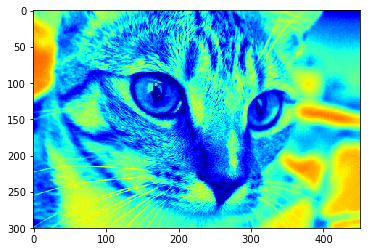

In [13]:
# Leo la imagen chelsea (es un gato)
chelsea = data.chelsea()

plt.imshow(chelsea[:,:,2],cmap = 'jet')

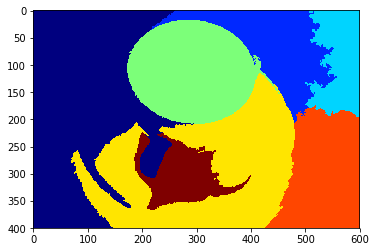

In [37]:
plt.imshow(slic(data.coffee(),n_segments=10),cmap='jet')

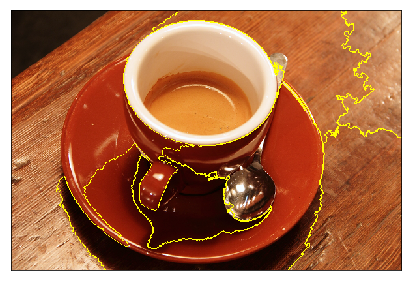

In [38]:
imshow(mark_boundaries(data.coffee(),slic(data.coffee(),n_segments=10)))

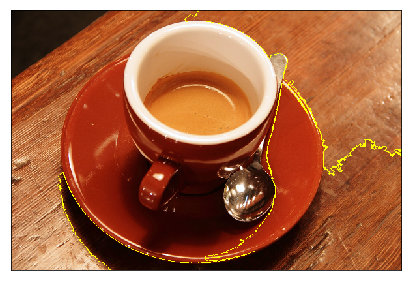

In [9]:
imshow(mark_boundaries(data.coffee(),
                       slic(data.coffee(),
                            n_segments=5)))

## Otros tipos de segmentación

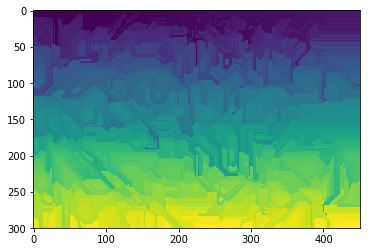

In [47]:
segmentationChelsea = felzenszwalb(chelsea,multichannel=True,sigma=5)
plt.imshow(segmentationChelsea)

In [48]:
len(np.unique(segmentationChelsea))

1983

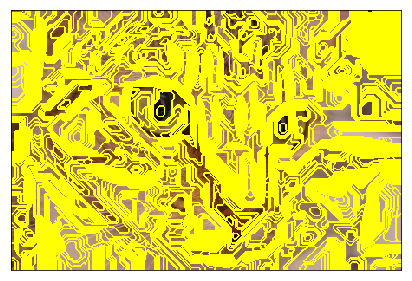

In [49]:
imshow(mark_boundaries(chelsea,
                       segmentationChelsea))

In [12]:
quickSegmentation = quickshift(chelsea,kernel_size=20, max_dist=5)

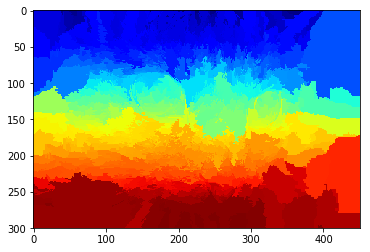

In [13]:
plt.imshow(quickSegmentation, cmap='jet')

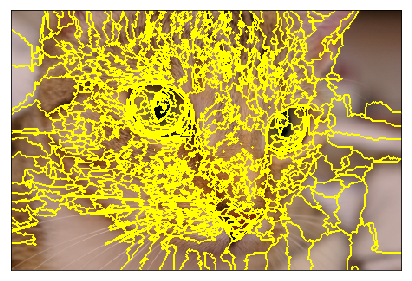

In [14]:
imshow(mark_boundaries(chelsea,
                       quickSegmentation))

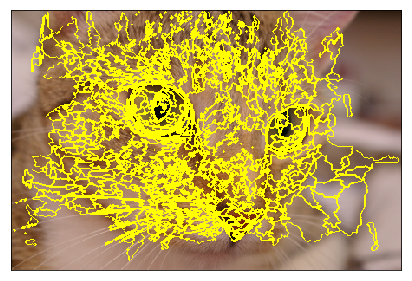

In [15]:
# Limpiar los bordes
imshow(mark_boundaries(chelsea,
                       clear_border(quickSegmentation)))

## Agregación multiescala

In [23]:
from skimage import data, io, segmentation, color
from skimage.future import graph
import numpy as np


def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.node[dst]['mean color'] - graph.node[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}

In [24]:
def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.node[dst]['total color'] += graph.node[src]['total color']
    graph.node[dst]['pixel count'] += graph.node[src]['pixel count']
    graph.node[dst]['mean color'] = (graph.node[dst]['total color'] /
                                     graph.node[dst]['pixel count'])

In [25]:
img = data.coffee()
labels = segmentation.slic(img, compactness=30, n_segments=400)
g = graph.rag_mean_color(img, labels)

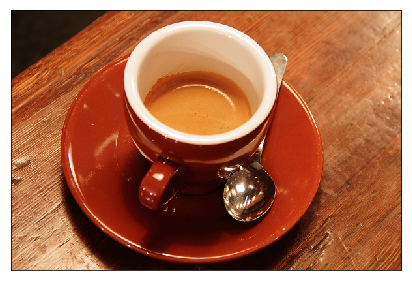

In [26]:
imshow(img)

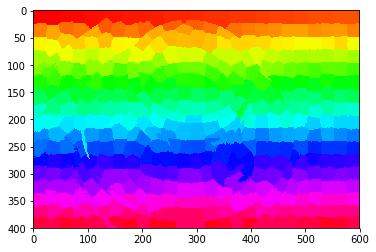

In [28]:
plt.imshow(labels,cmap = 'hsv')

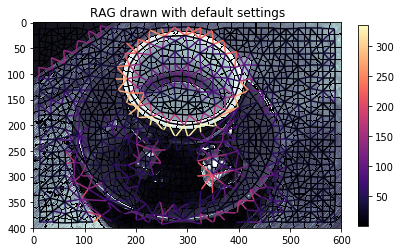

In [20]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 8))

ax.set_title('RAG drawn with default settings')
lc = graph.show_rag(labels, g, img, ax=ax)
# specify the fraction of the plot area that will be used to draw the colorbar
fig.colorbar(lc, fraction=0.03, ax=ax)

In [21]:
labels2 = graph.merge_hierarchical(labels, g, thresh=35, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_mean_color,
                                   weight_func=_weight_mean_color)

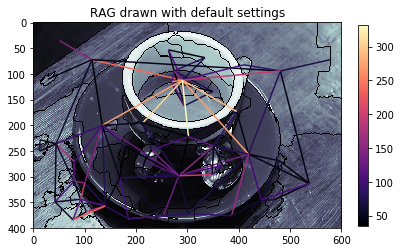

In [22]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 8))

ax.set_title('RAG drawn with default settings')
lc = graph.show_rag(labels, g, img, ax=ax)
# specify the fraction of the plot area that will be used to draw the colorbar
fig.colorbar(lc, fraction=0.03, ax=ax)

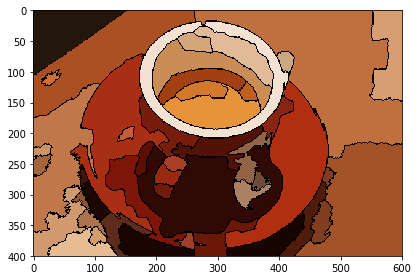

In [23]:
out = color.label2rgb(labels2, img, kind='avg')
out = segmentation.mark_boundaries(out, labels2, (0, 0, 0))
io.imshow(out)
io.show()